# From LM-GC Plasticity Model to CAN model of Grid cells
The Toy Plasticity Model was an auto-associative $1D$ model whose goal was to:
- Give the system a LM unit that is able to recognize periodicity and phase of landmarks
- Learns the GC frequencies / phases matching external rhythm
- Generates internal landmark drive even when external signal is not visible

In other words, LM teaches the brain which internal module has the correct frequency and which phase in that model aligns with the external landmark, and after learning, LM can fire at the right times even without sensory landmarks.

### Given that an internal landmark signal exists, how does it shape the dynamics of a CAN and the variability of timing?
The goal of the CAN model is to show the effects of endogenous landmarks on **path integration** and **timing** and **simulate the post-learning scenario**.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
from typing import Tuple

## 0. CAN Model - Conceptual description
The CAN model is a **$1D$ continuous attractor network that**
- maintains a **single activity bump** on a ring of neurons
- moves this bump smoothly along the ring according to a **noisy velocity input** (path integration)
- keeps the bump rigid (preserves shape, only translates it around the ring)
- optionally receives **internal landmark inputs** at specific phases on the ring
- produces bump trajectories and reaction times (time to reach an end phase)

A canonical CAN: (all CANs??? what's the definition?)
- has neurons arranged on a *ring* ($1D$ circular manifold)

- has **translation invariant connectivity** (each neuron excites near neighbors inhibits far ones)

- supports a **stable bump of activity**:
    - a localized hill of firing that can move smoothly along the ring

- bump position $\leftrightarrow$ internal representation of a variable (eg. phase, time, location)


# 1. Network architecture
We model a single module (the LM-matched module) as an independent ring attractor.

- ### Left and Right populations
    Given a number of neurons $K$ ( e.g. $360$):\
    it is made by 2 populations *(L)* and *(R)* forming one unified ring, representing two directionally biased copies of the same $1D$ ring.
    - Right population (R): neurons $0, \dots, K-1$
    - Left population (L): neurons $K, \dots, 2K-1$

    The total number of neurons is then $2K$.

- ### Mexican-hat connectivity matrix (Difference of Gaussians)
    We define a 1D lateral connectivity kernel on the ring

    $\text{MexHat}[k] = A_{\text{exc}}\exp(-s_{\text{exc}}z^2_k) - A_{\text{inh}}\exp(-s_{\text{inh}}z^2_k)$

    - $z_k \in \{-\frac{K}{2}, \dots, \frac{K}{2}-1\}$ is the circular distance
    - $A_{\text{exc}}$, $A_{\text{inh}}$ are amplitudes
    - $s_{\text{exc}}$, $s_{\text{inh}}$ are control widths

    This kernel has:
    - local excitation (narrow Gaussian)
    - broader inhibition (larger Gaussian)

    It ensures a **single stable bump** and is built such that **neighbours excite neighbours**:
    - Neurons near bump center must excite each other to maintain bump height
    - Neurons far away must inhibit each other to prevent multiple bumps from appearing

- ### Directionally biased synapses

    We build four $K \times K$ weight matrices such that each row defines **incoming** weights onto neuron $i$:
    - **2 Directional**: they create a **bump drift** (clockwise for right direction, counterclockwise for left)
        - $W_{RR}$: $R \leftarrow R$
        - $W_{LL}$: $L \leftarrow L$

        They 
    - 2 coupling the two populations: enforce a single bump is shared between L and R
        - $W_{RL}$: $R \leftarrow L$
        - $W_{LR}$: $L \leftarrow R$
    
    This makes the model a continuous attractor network with **direction selectivity**
    

- ### Initialization parameters:

    Initiate class CAN_Network using structural parameters, which follow *Burak & Fiete (2009)*
    - $K$: (364) number of ring neurons in a population

    - Numerics: 
        - $dt$: step size of numerical integration (s)
        - $\tau_s$: synaptic time constant (s)

    - Drive    
        - $\beta_{\text{vel}}$: gain on velocity input (controls how strongly the bump moves per unit velocity)
        - $\beta_0$: global feedforward excitatory drive amplitude (sets how excitable the network is)
    
    - mexhat: built using connectivity shape parameters: 
        - $A_{\text{exc}}$, $A_{\text{inh}}$ 
        - $s_{\text{exc}}$, $s_{\text{inh}}$

- ### Task-specific parameters:
    - baseline speeds used to compute velocity input $v(t)$, which is a noisy velocity input that is computed then kept constant per-trial
        - $\text{wolm\_speed}$: without internal landmarks
        - $\text{wlm\_speed}$: with internal landmarks
    - $\text{wm}$: Weber fraction controlling speed noise

    - $\text{landmark\_input\_loc}$: array of neuron indices indicating the phases at which endogenous landmarks are stored


*RK)* the paper doesn't go parameter-by-parameter with biological justification. They say that the CAN was adapted from *Burak & Fiete* + they did grid searches over velocity to match the behavioral periodicity and ensure robustness across Weber fractions

Eg. $\beta_{\text{vel}}$ was calibrated so that with the chosen speeds $\text{wolm}$ $\text{wlm}$ the model reproduces the $\sim 0.65s$ periodicity and matched mean time to target

In [2]:
class CANNetwork:
    """
    1D Continuous Attractor Network (single module, two populations: Right & Left)
    Defines the architecture and the static parameters

    Attributes
    ----------
    K : int
        Number of neurons per ring (Right and Left populations each have N neurons).
        Total neurons = 2K.
    dt : float
        Integration time step (seconds).
    tau_s : float
        Synaptic time constant (seconds).
    beta_0 : float
        Global feedforward excitatory drive amplitude.
    beta_vel : float
        Gain on velocity input.
    
        
    mex_hat : np.ndarray, shape (N,)
        Base mexican-hat connectivity kernel on the ring.
    W_RR, W_LL, W_RL, W_LR : np.ndarray, shape (N, N)
        Synaptic weight matrices between populations:
        - W_RR: Right -> Right (shifted kernel, one direction)
        - W_LL: Left  -> Left  (shifted kernel, opposite direction)
        - W_RL: Left  -> Right (no shift)
        - W_LR: Right -> Left  (no shift)
    FF_global : np.ndarray, shape (N,)
        Constant feedforward input to each neuron in each population.
    """

    def __init__(
        self, 
        K: int,
        dt: float = 1.0 / 2000.0,
        tau_s: float = 40.0 / 1000.0, #(40 ms)
        beta_vel: float = 1.0, 
        beta_0: float = 100.0,
        ):

        self.K = K
        self.dt = dt
        self.tau_s = tau_s
        self.beta_vel = beta_vel
        self.beta_0 = beta_0

        # Global feedforward excitation
        self.FF_global = self.beta_0 * np.ones(self.K, dtype= float)

        # Build connectivity
        self.mexhat = self.build_mexhat()
        self.W_RR, self.W_LL, self.W_RL, self.W_LR = self.build_synapses()

    
    def build_mexhat(
            self,
            A_exc: float = 1000.0,
            s_exc: float = 1.05 / 100.0,
            A_inh: float = 1000.0,
            s_inh: float = 1.00 / 100.0
            ) -> np.array:
        z = np.arange(-self.K/2, self.K/2, 1.0)
        mex = A_exc * np.exp(-s_exc * z**2) - A_inh * np.exp(-s_inh * z**2)

        #circshitft by N/2 -1
        shift = int(self.K/2 -1)
        mex = np.roll(mex, shift)
        return mex.astype(float)
    

    def build_synapses(self) -> Tuple[np.array, np.array, np.array, np.array]:
        # returns (W_RR, W_LL, W_RL, W_LL)
        W_RR = np.zeros((self.K, self.K), dtype=float)
        W_LL = np.zeros((self.K, self.K), dtype=float)
        W_RL = np.zeros((self.K, self.K), dtype=float)
        W_LR = np.zeros((self.K, self.K), dtype=float)

        for i in range(self.K):
            # indexing 0, ..., K-1
            W_RR[i, :] = np.roll(self.mexhat, i-1)
            W_LL[i, :] = np.roll(self.mexhat, i+1)
            W_RL[i, :] = np.roll(self.mexhat, i)
            W_LR[i, :] = np.roll(self.mexhat, i)
        
        return W_RR, W_LL, W_RL, W_LR


# 2. CAN Simulation

It assumes a full CANNetwork with attributes $K$, $dt$, $\tau_s$, $\beta_\text{vel}$, $\beta_0$, $FF_\text{global}$, $W_\text{RR}$, $W_\text{LL}$, $W_\text{RL}$, $W_\text{LR}$

- ### Initialization
    It is a $10s$ dynamics that is not modeling sensory landmarks, but it is stabilizing the network into a proper attractor bump before the task begins.
    - No task stimuli
    - No learned landmarks
    - No external cues
    - Just initialize the bump attractor to a stable state

    **Biological interpretation**: In the brain, grid-cell attractor dynamics don’t start from random noise at the beginning of every trial — they are already in a stable state from previous activity. 

    The “landmark” here is just a weak Gaussian to ensure the bump starts somewhere predictable.

- ### During run_trial (CAN model)
    - The subject performs the internal timing task.
    - Landmarks do not correspond to external stimuli (there are no external cues in the reproduction phase)
    - Only internal landmark triggers (if landmarkpresent=True), and they are triggered by the bump reaching certain internal phases.
    - These internal triggers reduce drift variance and explain the periodicity seen in behavior.

### Big picture at time step $t$:

- We compute one noisy velocity sample per trial and keep it constant over time: $v(t)= v_\text{base} + v_\text{noise}$
    - with landmarks $\rightarrow$ $v_\text{base} = \text{wlm\_speed}$
    - without landmarks $\rightarrow$ $v_\text{base} = \text{wolm\_speed}$
- Get current state $s_L$, $s_R$ (current activity vectors of the left and right ring neuron populations) (K-dimensional vectors)
- Compute how velocity biases left / right populations
    - $v_L$, $v_R$: the velocity gains for both populations given the $\beta_\text{vel}$ of the network and the velocity input
    - they modulate how strongly the recurrent input moves the bump left / right
- Compute recurrent synaptic input from the network
    - $g_\text{RR}$, $g_\text{LL}$, $g_\text{RL}$, $g_\text{LR}$
    - computed from the network connectivity weights and the left / right activity vectors
    - represent how neurons from either population excite each others (e.g. how R neurons influence L and viceversa for all combinations)

- if internal landmarks are enabled and the bump peak is at / near one:
    - compute a landmark input bump
    - add it to the total pre-activation current of both populations 
        - $G_L$, $G_R$: total pre-activation current
            - $G_L$: 'into-left direction contribution': $g_{LL} + g_{LR} + FF_{\text{global}} + \text{lm\_input}$, scaled by velocity modulation $v_L$
            - $G_R$: 'into-right direction contribution': $g_{RL} + g_{RR} + FF_{\text{global}} + \text{lm\_input}$, scaled by velocity modulation $v_R$
- $G = [G_L, G_R]$    
- $F = \text{ReLU(G)}$: Burak & Fiete use a threshold-linear (ReLU) activation
    - firing rate
- Find where the bump is now (track $\text{nn\_state}$)

- Euler step
    - The activity at successive time step is updated: $s(t) = s(t-1) + (F - s(t-1)) * dt / \tau_s$
    -  s is the smoothed state (low-pass filter with $\tau_s$)

    **Why this architecture produces a moving bump**:
    - According to Burak & Fiete ring attractor
        - Recurrent Mexican-hat connectivity stabilizes a single peak of activity
        - Velocity modulation makes one side stronger $\rightarrow$ bump shifts
        - Low-pass dynamics smooth the motion
    
    - NFJ24 becomes:
        - uses two rings (L and R)
        - adds landmark-triggered input
        - tracks where the bump moves


In [6]:
mypath = os.path.abspath("..")
print("CWD:", os.getcwd())
sys.path.insert(0, mypath)

CWD: /Users/clara/Desktop/MAI/Anno 2/Sem 1/Neuro/Neupane Project/mental-navigation/src/mental_navigation/CAN


In [7]:
from CAN.CAN_simulator import CANSimulator

In [8]:
netw = CANNetwork(K=10)

In [9]:
K = 10
netw = CANNetwork(K)
model = CANSimulator(netw)

In [12]:
landm_input = model.generate_landmark_input(
    centers= [7],
    std= 2.0,
    ampl_scaling = 10.0)

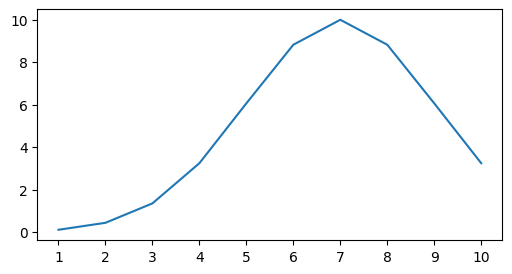

In [13]:
plt.figure(figsize = (6,3))
plt.plot(np.arange(1, K+1), landm_input)
plt.xticks(np.arange(1, K+1))
plt.show()

### initial activity created
From the synaptic construction in CANNetwork, which mirrors Burak & Fiete (2009), the Left (L) and Right (R) populations are two copies of the same ring attractor. They are wired with slightly shifted recurrent connectivity in opposite directions.

As a result, their bumps are:
- identical in shape
- stable

but systematically phase-shifted with respect to each other. This allows velocity-driven motion of the bump.

#### Interpretation:
within-population connectivity:
- $L \leftarrow L$ connections are shifted by $+1$
- $R \leftarrow R$ onnections are shifted by $-1$

Cross-population connectivity:
- $L \leftarrow R$ and $R \leftarrow L$ are unshifted

It's like each ring wants to form a stable bump due to the Mexican-hat kernel, but the preferred alignment of that bump depends on how the kernel is shifted. This makes the two population bumps be slightly shifted in opposite directions. The two populations are always active together, and settle into a **consistent phase relationship**

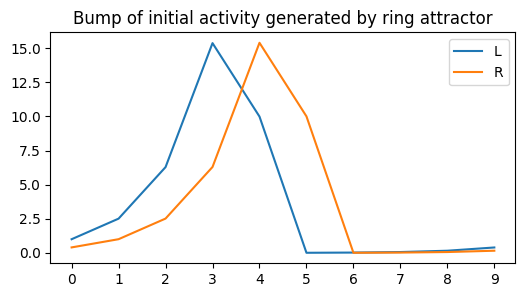

In [29]:
init_activity = model.init_state()
plt.figure(figsize = (6,3))
plt.plot(np.arange(0, K), init_activity[:K], label='L')
plt.plot(np.arange(0, K), init_activity[K:], label='R')
plt.xticks(np.arange(0, K))
plt.title("Bump of initial activity generated by ring attractor")
plt.legend()
plt.show()

Given:
- init_state
- parameters needed to create the landmark bump to inject
- params to initialize per-trial noisy velocity input



**clarifications**:
- the landmark gaussian has an amplitude amp(t) which is a gaussian in time. starts near 0 when we enter the region, grows to a peak and decays again with temporal scale tau
- landmark onset steps: when the bump phase crosses the landmark location, we say we enter the region of landmark. landmarl onset steps is the number of time steps taken after entering this region until reaching the peak in amplitude.

- landmark tau steps: the number of time steps taken for the amplitude to decay from the peak.\
    this means that internal landmarks are not an instantaneous kick, but a temporally extended boost around each learned phase.

    - if one unit step takes dt = 1/10 s -> landmark onset steps=500 means that 500 steps are required to reach the peak-> in seconds, 500*dt = 50


in each time step
- current velocity -> pick one noisy velocity per trial and keep it constant (using fine-tuned params by Neup&al)
- CAN dynamics: get current state and let the network evolve until phase threshold or time limit
- compute velocity biases
- compute recurrent synaptic inputs (recurrent contributions from the ring attractor)

- if we are at / near a landmark:
    - copute a landmark input bump and add it to both populations
- appply relu and update activity (euler step)
- stop when bump phase passes end_phase or when we hit time limit



tracking:
- nn_state: 1d list of bump center positions, written in terms of indices of ring neurons
- landmark bookkeeping:
    - lm_locs: ring neuron indices (phases) where learned landmarks live (list)
    - lm_flag: tells at which lm (lm k) we are in now (0 means none seen yet)
    - lm_times[k]: the time step when we first entered landmark region for landmark k

In [86]:
lm_locs = np.array([3.0, 7.0, 10.0])
phase = 2.0

last_lm_locs = [loc for loc in lm_locs if loc <= phase]
if last_lm_locs:
    last_lm_loc = last_lm_locs[-1]
    last_lm_idx = len(last_lm_locs)
else:
    last_lm_loc = None
    last_lm_idx = None


In [87]:
last_lm_locs, last_lm_idx

([], None)

In [67]:
K=10
ring = np.arange(0,10)
bump = np.array([3,7,6,3,4,3,4,5,6,3])
last_idx = 8
window = np.arange(last_idx-3, last_idx+4)
window_mod = window % K
bump_window = bump[window_mod]
idx_max_window = np.argmax(bump_window)
idx_max_ring = (last_idx-3+idx_max_window)%K

print(f'ring: {ring}')
print(f'bump: {bump}\n')
print(f'last_idx: {last_idx}, bump value: {bump[last_idx]}')
print(f'window: {window}')
print(f'window_mod: {window_mod}')
print(f'bump_window: {bump_window}')
print(f'idx_max_window: {idx_max_window}')
print(f'idx_max_ring: {idx_max_ring}')


ring: [0 1 2 3 4 5 6 7 8 9]
bump: [3 7 6 3 4 3 4 5 6 3]

last_idx: 8, bump value: 6
window: [ 5  6  7  8  9 10 11]
window_mod: [5 6 7 8 9 0 1]
bump_window: [3 4 5 6 3 3 7]
idx_max_window: 6
idx_max_ring: 1


In [49]:
len(bump)

9